In [4]:

#---- Sesion 2: ODEs en Python y estimacion de parametros 

#--Resolviendo ODEs en Python con Scipy

#Dos opciones

# 1) odeint : salio antes y utiliza lsoda del paquete de FORTRAN odepack para resolver ODEs
# 2) solve_ivp: es mas general y permite elegir el integrador. Se puede elegir method=lsoda y es el mismo
#    Otros metodos que tiene solve_ivp  RK45 (default) , RK23, DOP853, Radau, BDF, LSODA
#    solve_ivp es mas lento, pues fue escrito en python


import numpy as np
import scipy
import scipy.stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

sns.set_theme(style="darkgrid") 


In [6]:
#---- solve_ivp
#initial value problem

from scipy.integrate import solve_ivp
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
# solve_ivp(fun, t_span, y0, method='RK45', args=None)
# def fun(t , y , par1, par2, ..., parm):
#     y es un arreglo
#     los parametros par1, par2,...,parm los paso como lista () en args


def sir(t, y, beta, gamma, N):
  S,I,R=y
  dSdt=-beta/N*I*S
  dIdt= beta/N*I*S- gamma*I
  dRdt= gamma*I
  return [dSdt, dIdt, dRdt     ]


#parametros
N=763
beta=1.89
gamma=0.48
S0=N-1
I0=1
R0=0

tspan=[0,14] #tiempos
y0=[S0, I0, R0] #condicion inicial 

sol = solve_ivp(sir  , tspan, y0, args=( beta, gamma, N    ))

#la solucion es dada por sol.y

Text(0, 0.5, 'Solutions')

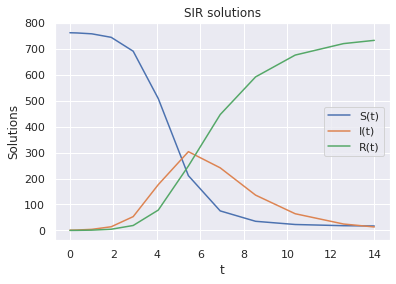

In [9]:
t = sol.t.T

#soluciones no continuas
plt.plot(t,sol.y.T[:,0], label='S(t)'  ) #S(t)
plt.plot(t,sol.y.T[:,1], label='I(t)'  ) #I(t)
plt.plot(t,sol.y.T[:,2], label='R(t)'  ) #R(t)
plt.legend()
plt.title('SIR solutions')
plt.xlabel('t')
plt.ylabel( 'Solutions')



Text(0, 0.5, 'Solutions')

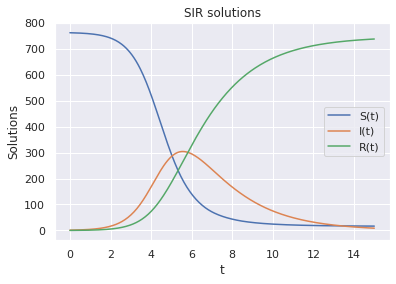

In [14]:
sol = solve_ivp(sir  , tspan, y0, args=( beta, gamma, N    ), dense_output=True)

t = np.linspace(0, 15, 300)
ssol=sol.sol(t)

#soluciones continuas
plt.plot(t,ssol.T[:,0], label='S(t)'  ) #S(t)
plt.plot(t,ssol.T[:,1], label='I(t)'  ) #I(t)
plt.plot(t,ssol.T[:,2], label='R(t)'  ) #R(t)
plt.legend()
plt.title('SIR solutions')
plt.xlabel('t')
plt.ylabel( 'Solutions')


In [15]:
#--- odeint
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
from scipy.integrate import odeint

#scipy.integrate.odeint(func, y0, t, args=(), 
# def func( y, t, par1, ..., parm):
#   par1,...,parm pasados como lista
# t es el arreglo de tiempos donde quiero la solucion


N=763

def sir(y,t, beta, gamma):
  S,I,R=y
  dSdt=-beta/N*I*S
  dIdt= beta/N*I*S- gamma*I
  dRdt= gamma*I
  return [dSdt, dIdt, dRdt     ]


In [16]:
#parametros
N=763
beta=1.89
gamma=0.48
S0=N-1
I0=1
R0=0
y0=[S0, I0, R0] #condicion inicial 

t=np.linspace(0,14,100)
sol = odeint(sir, y0, t, args=(beta, gamma))

St= sol[:,0]
It= sol[:,1]
Rt= sol[:,2]

Text(0, 0.5, '')

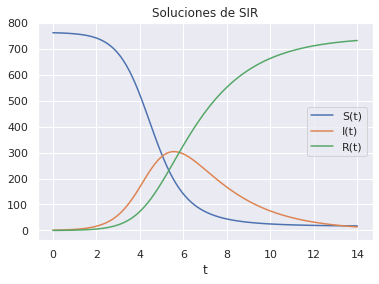

In [18]:
plt.plot(t,St, label='S(t)'  ) #S(t)
plt.plot(t,It, label='I(t)'  ) #I(t)
plt.plot(t,Rt, label='R(t)'  ) #R(t)
plt.legend()
plt.title('Soluciones de SIR')
plt.xlabel('t')
plt.ylabel( '')

Text(0.5, 1.0, 'Infectados reales y observados')

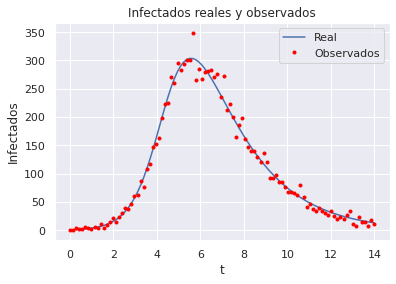

In [25]:
#Ahora que puedo generar soluciones, podemos agregar ruido

# Suponga que se observa unicamente los infectados con algun ruido.
# Sea y_t ~ Po( It ), observamos los infectados con un ruido de Poisson.

yt= scipy.stats.poisson.rvs( It )

plt.plot(t,It, label='Real' )
plt.plot(t, yt, '.', color='red', label='Observados')
plt.xlabel('t')
plt.ylabel('Infectados')
plt.legend()
plt.title('Infectados reales y observados')





In [28]:

# Ver:
# https://arxiv.org/pdf/1903.00423v3.pdf Contemporary statistical inference for infectious disease models using Stan
# https://arxiv.org/pdf/2006.02985.pdf Bayesian workflow for disease transmission modeling in Stan
# MCMC HMC Hamiltonian Monte Carlo ---> STAN


#----- Problema Inverso: Dados los datos y_t del siguiente problema, como encuentro los parametros
# beta, gamma, S(0)?

#----- Ejemplo

# Problema: Influenza A H1N1  Escuela Britanica 1978 22 enero-04 de febrero
# Datos observados: Conteos diarios Y_t del numero de estudiantes infectados en un periodo de 14 dias
# N=763 estudiantes, 512 se enfermaron 

# Capitulo 9 De Vries et al. (2006) 
# Disponibles en RECON https://www.repidemicsconsortium.org 


# Verosimilitud: y_t ~ Poisson(I_t) 
# solamente se observan los infectados

# Prioris: 
#    beta ~ lognormal(0,1)
#    gamma ~ Gamma(0.02, 0.004 ) Tiempo medio de infeccion sea 5 dias
#    S(0)/N ~ beta( 0.5, 0.5 ) 



#datos, personas infectadas
yt=np.array(   [3,8,28,76,222,293, 257, 237, 192, 126, 70, 28, 12, 5]    )
t=np.arange(1,15,1)


Text(0.5, 1.0, 'Numero de ninos infectados UK 1978')

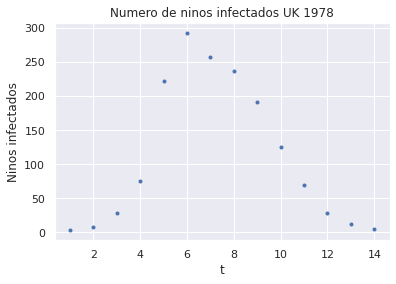

In [27]:
plt.plot(t,yt, '.')
plt.xlabel('t')
plt.ylabel('Ninos infectados')
plt.title('Numero de ninos infectados UK 1978')


In [31]:
#  t-walk, Dr Jose Andres Christen
# "A General Purpose Sampling Algorithm for Continuous Distributions"
# MCMC that does not required tuning.

#Implementado en C++, Python, R, Julia, MatLab
# https://www.cimat.mx/~jac/twalk/

#Christen, J.A. and Fox, C. (2010), "A General Purpose Sampling Algorithm for
#Continuous Distributions (the t-walk)", Bayesian Analysis, 5(2), 263-282.

# The paper is available online at: http://projecteuclid.org/euclid.ba/1340218339


# Para usar el t-walk basta darle
# 2 puntos iniciales distintos
# Funcion que revise el soporte de la posterior
# Funcion Energia U=-log p(\theta|x)

import pytwalk as twalk
#descargar y poner en archivos

#generalizacion del t-walk -> emcee

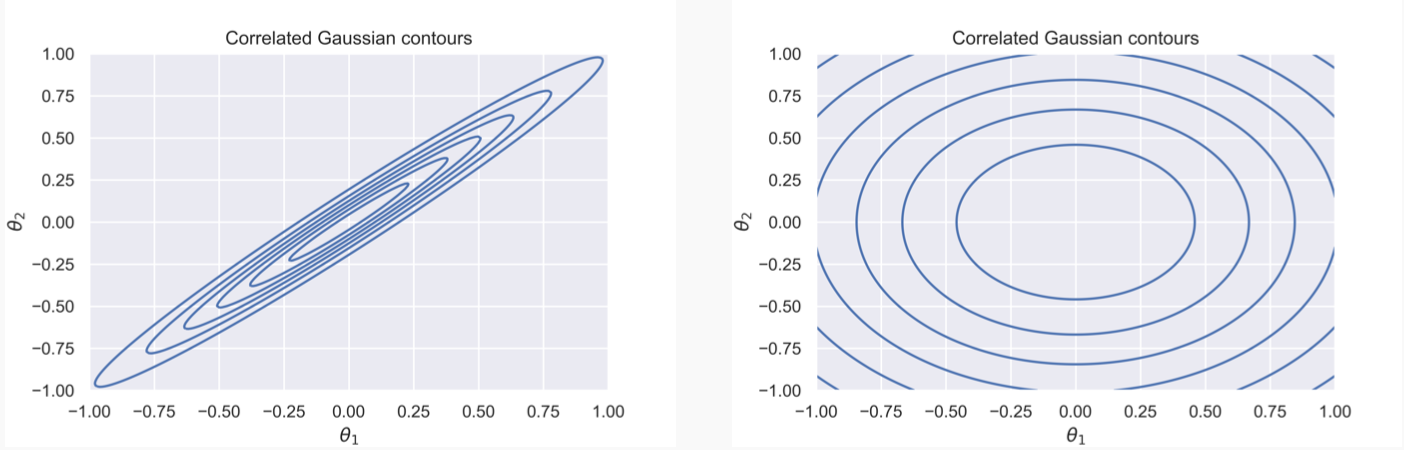

In [29]:
# SIR

N=763
def sir(y,t, beta, gamma):
  S,I,R=y
  dSdt=-beta/N*I*S
  dIdt= beta/N*I*S- gamma*I
  dRdt= gamma*I
  return [dSdt, dIdt, dRdt ]

#log Prior

# Prioris: 
#    beta ~ lognormal(0,1)
#    gamma ~ Gamma(0.02, 0.004 )  //Assume mean infectious period = 5 days  
#    s0=S(0)/N ~ beta( 0.5, 0.5 ) 

#def logPrior(theta):
 # beta, gamma, s0=theta
  #temp= -np.log(beta)-np.log(np.log(beta/2))-0.98*np.log(gamma)-0.004*gamma -0.5 *np.log( s0 )-0.5*np.log(1-s0)
  #return temp

def logPrior(theta):
  beta, gamma, s0=theta
  temp=scipy.stats.beta.logpdf(s0,0.5, 0.5 )+scipy.stats.lognorm.logpdf(beta, s=1)+ scipy.stats.gamma.logpdf(gamma, a=0.02, loc=0, scale=1/0.004)
  return temp
  
#log Likelihood
def logL(theta):
  beta, gamma, s0=theta
  S0=N*s0
  I0=N-S0
  R0=0
  y0=[S0, I0, R0] #condicion inicial 
  sol = odeint(sir, y0, t, args=(beta, gamma))
  St, It, Rt= sol[:,0], sol[:,1], sol[:,2] # y_t ~ Po(I_t(theta))
  temp=-np.sum( It  )+np.sum(yt*np.log(It))
  return temp

#Energia U=-log Posterior
def U(theta):
  return -(logL(theta)+logPrior(theta))


#--- Funciones auxiliares

def tplot(x, variable ): #funcion para ver trazas
  plt.plot(x)
  plt.xlabel('t')
  plt.ylabel( variable)
  plt.title('traceplot')

def histmh(x, variable,  flag=False): #funcion para ver histogramas 
  sns.displot(x, kde=flag, bins=15)  
  plt.xlabel('x')
  plt.title('Histograma de '+ variable)




In [30]:
#t-walk

def p0(): #initial point function for the t walk
  beta=scipy.stats.lognorm.rvs( loc=0,s=1, scale=1, size=1)
  gamma=scipy.stats.gamma.rvs(a=0.02, scale=1/0.004, size=1) 
  s0=scipy.stats.beta.rvs(a=0.5,b=0.5, size=1)
  return np.array([ beta[0], gamma[0], s0])

def supp(theta): #funcion de soporte , el t-walk lo va proponiendo
  beta, gamma, s0=theta
  if(beta>0 and gamma>0 and s0>0 and s0<1):
    return True
  else:
    return False
  

In [33]:
T=100000 #number of iterations

#100000 ~ 3 min
# 1e6 iteraciones ~ 35 minutos

x0=p0() #punto inicial 1
xp0=p0() #punto inicial 2

tchain = twalk.pytwalk( n=3, U=U, Supp=supp )
tchain.Run( T=T , x0= x0 , xp0= xp0)

pytwalk: Running the twalk with 100000 iterations .  Thu, 08 Oct 2020, 18:19:54.
       Finish in approx. 5 min and 25 sec.


/content/pytwalk.py:433: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) + (W1 - W2))
/content/pytwalk.py:349: RuntimeWarning: overflow encountered in exp
  A = exp((up - up_prop) +  (self.nphi-2)*log(beta))
/content/pytwalk.py:366: RuntimeWarning: overflow encountered in exp
  A = exp((u - u_prop) +  (self.nphi-2)*log(beta))


pytwalk:      19456 iterations so far. Finish in approx. 2 min and 10 sec.
pytwalk:      55296 iterations so far. Finish in approx. 1 min and 14 sec.
pytwalk: finished, Thu, 08 Oct 2020, 18:22:40.


1

Acceptance rates for the Walk, Traverse, Blow and Hop kernels:[0.33315789 0.17600507 0.00356295 0.01752336]
Global acceptance rate: 0.25083
AutoMaxlag: maxlag= 608.
Integrated Autocorrelation Time:    72.9, IAT/n:    24.3
AutoMaxlag: maxlag= 608.


matrix([[72.88083537]])

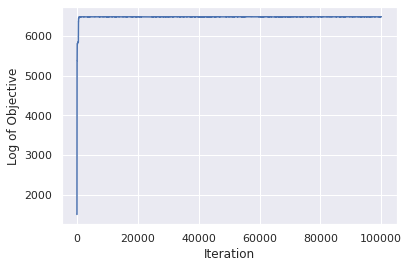

In [34]:

tchain.Ana()
tchain.IAT()


#--- IAT: Integrated autocorrelation time
# Geyer 1992 https://projecteuclid.org/euclid.ss/1177011137
# IAT: Es una medida de la fuerza de independencia de nuestra cadena/ exceso de varianza por autocorrelacion 
# n_{eff}=n/IAT , n_{eff} es la cantidad de observacines independientes que tiene nuestra cadena


In [35]:
print('Tamano de muestra efectivo: ', T/72.9 ) #sad=

Tamano de muestra efectivo:  1371.7421124828531


In [36]:
toutput=tchain.Output[:, 0:3 ]

beta=toutput[:,0]
gamma=toutput[:,1]
s0=toutput[:,2]

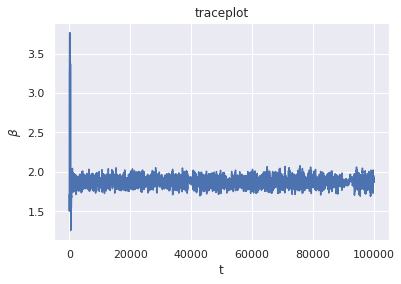

In [37]:
tplot(beta, r'$\beta$'  )

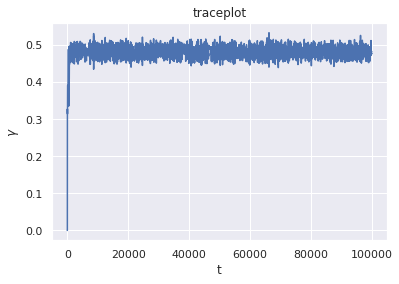

In [38]:
tplot(gamma, r'$\gamma$'  )

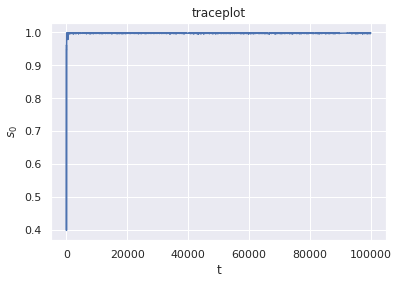

In [43]:
tplot(s0, r'$s_0$'  )

In [44]:
#burnin
bi=int(0.20*T)

beta=toutput[bi:,0]
gamma=toutput[bi:,1]
s0=toutput[bi:,2]
r0=beta/gamma #calculando r0 

resultados={'beta': beta, 'gamma':gamma, 's0':s0, 'r0':r0}
resultados=pd.DataFrame(resultados)

pd.DataFrame.describe(resultados)


,beta,gamma,s0,r0
count,80001.000000,80001.000000,80001.000000,80001.000000
mean,1.871948,0.481284,0.997850,3.890838
std,0.054679,0.011584,0.000445,0.121259
min,1.688740,0.439209,0.995999,3.417569
25%,1.836712,0.473231,0.997594,3.809191
50%,1.871864,0.481614,0.997888,3.885445
75%,1.906294,0.489002,0.998156,3.967831
max,2.076782,0.533290,0.999101,4.399694


In [45]:
#Mediana posterior
medianas=pd.DataFrame.median(resultados)
print(medianas)

beta     1.871864
gamma    0.481614
s0       0.997888
r0       3.885445
dtype: float64


In [46]:
#Cuantiles
pd.DataFrame.quantile(resultados, (0.025, 0.975))

,beta,gamma,s0,r0
0.025,1.762485,0.458319,0.996857,3.663037
0.975,1.985058,0.503552,0.998625,4.149160


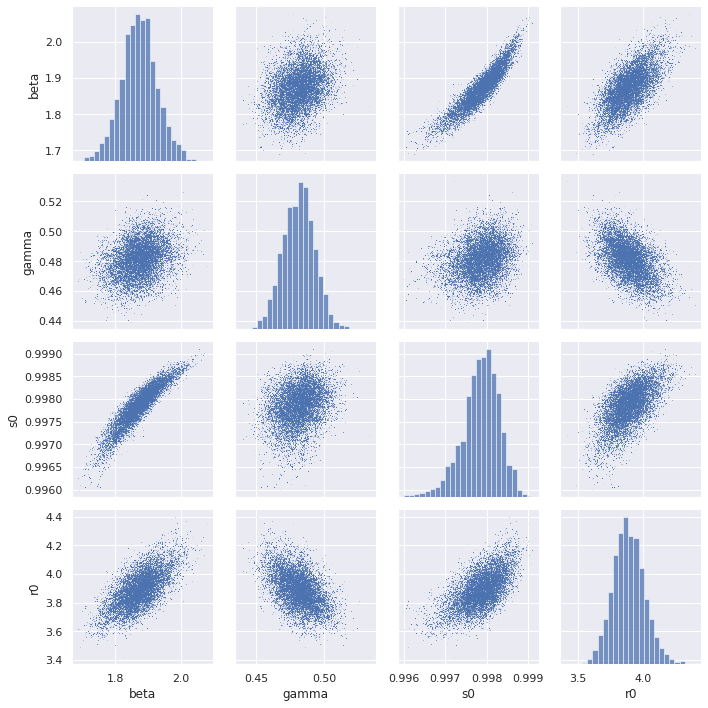

In [47]:

sns.pairplot(resultados, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=25) )
plt.tight_layout()
plt.savefig('twpairplot.png', dpi=500)

In [48]:
#------ Que tan bueno es el ajuste?

#---Funcion auxiliar

def solvesir( beta, gamma, s0 ):
  S0=N*s0
  I0=N-S0
  R0=0
  y0=[S0, I0, R0] #condicion inicial 
  sol = odeint(sir, y0, t, args=(beta, gamma))
  return sol
  


Text(0, 0.5, 'I(t)')

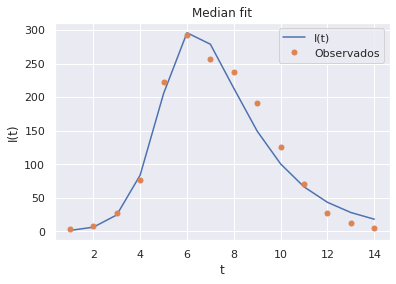

In [49]:
#Ajuste con la mediana posterior

medianfit=solvesir(medianas[0],medianas[1], medianas[2]  )

plt.plot(t,medianfit[:,1], label='I(t)'  ) #I(t)
plt.plot(t, yt, '.', label='Observados', markersize=10)
plt.legend()
plt.title('Median fit')
plt.xlabel('t')
plt.ylabel( 'I(t)') 


Text(0, 0.5, 'S(t)')

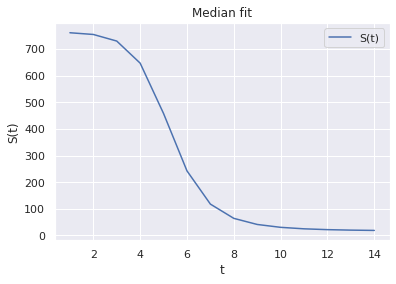

In [51]:
plt.plot(t,medianfit[:,0], label='S(t)'  ) #I(t)
plt.legend()
plt.title('Median fit')
plt.xlabel('t')
plt.ylabel( 'S(t)') 

Text(0, 0.5, 'R(t)')

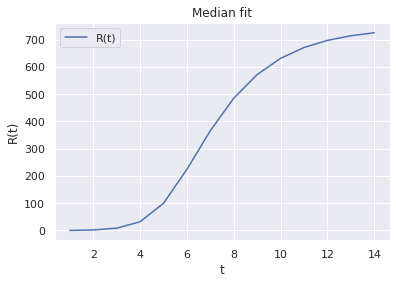

In [52]:
plt.plot(t,medianfit[:,2], label='R(t)'  ) #I(t)
plt.legend()
plt.title('Median fit')
plt.xlabel('t')
plt.ylabel( 'R(t)') 

Text(0, 0.5, 'I(t)')

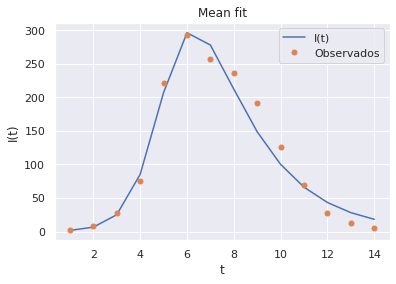

In [53]:
#Ajuste con la media posterior

meanfit=solvesir(np.mean(beta), np.mean(gamma), np.mean(s0))

plt.plot(t,meanfit[:,1], label='I(t)'  ) #I(t)
plt.plot(t, yt, '.', label='Observados', markersize=10)
plt.legend()
plt.title('Mean fit')
plt.xlabel('t')
plt.ylabel( 'I(t)') 


In [54]:
#--- La predictiva
#https://people.stat.sc.edu/Hitchcock/stat535slidesday18.pdf
# https://stats.stackexchange.com/questions/185311/why-does-sampling-from-the-posterior-predictive-distribution-px-new-mid-x-1

#  p( y^* | y  )= \int_{\Theta} p(y^*| y, \theta) p(\theta | y)  d\theta

#Funcion auxiliar para generar predictivas

def predobs( beta, gamma, s0, tup=14  ,sample_size=150 ):
    L=len(beta)
    obs=np.zeros([ sample_size  , tup]) 

    Sts=np.zeros([ sample_size  , tup]) 
    Its=np.zeros([ sample_size  , tup]) 
    Rts=np.zeros([ sample_size  , tup]) 
    
    ts=np.arange(1,tup+1, 1)

    #which observations to take into account for the predictive
    indexes=np.random.choice(a = np.arange( 0, L )   , size = sample_size, replace = False)
    
    sbetas=beta[indexes]
    sgammas= gamma[indexes]
    ss0s= s0[indexes]

    for i in range(sample_size ):
        sol=solvesir(sbetas[i], sgammas[i], ss0s[i])
        Sts[i]=sol[ :,0]
        Its[i]=sol[ :,1]
        Rts[i]=sol[ :,2]
        obs[i]=scipy.stats.poisson.rvs( Its[i] ) #y_t ~ Poisson(I_t(theta))
        
    return Sts, Its, Rts,  obs


In [55]:

# Distribucion predictiva
Sts, Its, Rts,  obspred =predobs( beta, gamma, s0,  sample_size=150)

indexes=np.random.choice(a = np.arange( 0,  obspred.shape[0] ), size =150, replace = False)
obs_samples=obspred[indexes]



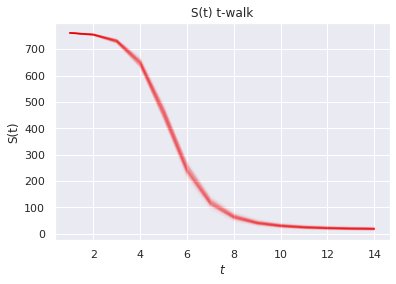

In [56]:
for i in range( len(obs_samples )  ):
    plt.plot(t, Sts[i], color='red' , alpha=0.01 )
plt.xlabel( r'$t$' )
plt.ylabel( r'S(t)' )
plt.title( 'S(t) t-walk' )
plt.savefig( 'twSt.pdf', dpi=500  )
plt.show()

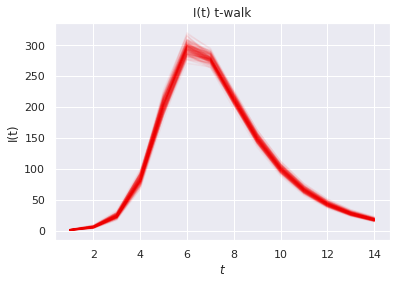

In [57]:
for i in range( len(obs_samples )  ):
    plt.plot(t, Its[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'I(t)' )
plt.title( 'I(t) t-walk' )
plt.savefig( 'twSt.pdf', dpi=500  )
plt.show()

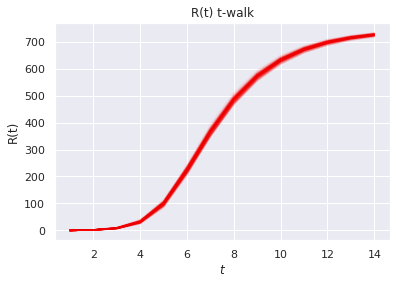

In [59]:
for i in range( len(obs_samples )  ):
    plt.plot(t, Rts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'R(t) t-walk' )
plt.savefig( 'twSt.pdf', dpi=500  )
plt.show()

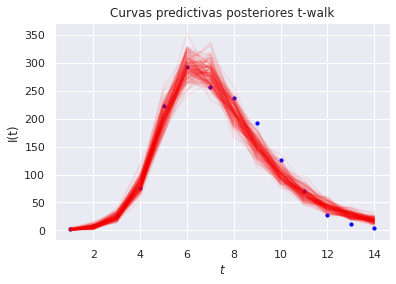

In [58]:
for i in range( len(obs_samples )  ):
    plt.plot(t,obs_samples[i], color='red' , alpha=0.07 )

plt.scatter(t,yt, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'I(t)' )
plt.title( 'Curvas predictivas posteriores t-walk' )
plt.savefig( 'twalkpredcurves.pdf', dpi=500  )
plt.show()